In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from postgres.config import SessionLocal
from postgres.models import BoxScores, ClusteredPlayers, TestPlayerPredictions, AdvancedPlayerStats

In [3]:
session = SessionLocal()

games = session.query(BoxScores).all()
data = []
for game in games:
    game_dict = {column.name: getattr(game, column.name) for column in game.__table__.columns}
    data.append(game_dict)
df = pd.DataFrame(data)
df = df[df['MIN'] != 0]
df
df = df.dropna(subset=['WL'])
df.describe()


,id,MIN,PTS,FGM,FGA,FG_PERCENT,THREE_PM,THREE_PA,THREE_PERCENT,FTM,...,STL,BLK,TOV,PF,PLUS_MINUS,FP,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,13577.000000,13577.000000,13577.000000,13577.000000,13577.000000,12835.000000,13577.000000,13577.000000,10818.000000,13577.000000,...,13577.000000,13577.000000,13577.000000,13577.000000,13577.000000,13577.000000,13055.000000,13055.000000,13055.000000,13055.000000
mean,6901.408927,22.462621,10.516314,3.844958,8.276276,45.385711,1.256169,3.497606,33.308763,1.570229,...,0.779996,0.472859,1.292922,1.756058,-0.000442,21.578478,21.642828,21.569631,21.496702,21.153396
std,4062.359591,10.852073,8.790667,3.237103,6.047304,23.929823,1.530746,3.160462,28.498558,2.216502,...,0.996452,0.834591,1.439510,1.436642,11.430666,14.941290,13.129132,12.710015,12.520382,12.155162
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-56.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3409.000000,15.000000,4.000000,1.000000,4.000000,33.300000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-7.000000,9.800000,11.666667,11.940000,11.992857,11.843875
50%,6811.000000,23.000000,9.000000,3.000000,7.000000,46.200000,1.000000,3.000000,33.300000,1.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,19.700000,20.133333,20.120000,19.928571,19.692000
75%,10211.000000,31.000000,16.000000,6.000000,12.000000,58.300000,2.000000,5.000000,50.000000,2.000000,...,1.000000,1.000000,2.000000,3.000000,7.000000,31.200000,30.033333,29.780000,29.557143,28.901923
max,14139.000000,50.000000,60.000000,22.000000,39.000000,100.000000,10.000000,20.000000,100.000000,17.000000,...,8.000000,10.000000,10.000000,6.000000,48.000000,98.300000,81.600000,80.120000,75.671429,72.200000


In [4]:
players = session.query(AdvancedPlayerStats).all()
clustered_players = session.query(ClusteredPlayers).all()

cluster_dict = {player.PLAYER: player.CLUSTER for player in clustered_players}
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {}
    player_dict['PLAYER'] = player.PLAYER
    # Assign the cluster if the player exists in clustered_players, else NAN
    player_dict['CLUSTER'] = cluster_dict.get(player.PLAYER, np.nan)
    data.append(player_dict)

dataset_clusters = pd.DataFrame(data)

In [5]:
dataset_clusters.head(10)

,PLAYER,CLUSTER
0,nicolas batum,0
1,deni avdija,12
2,alperen sengun,3
3,amir coffey,4
4,jaden mcdaniels,4
5,donte divincenzo,1
6,jalen wilson,7
7,julian strawther,14
8,luguentz dort,5
9,michael porter jr.,1


In [6]:
clusterDict = {}
df.describe()

,id,MIN,PTS,FGM,FGA,FG_PERCENT,THREE_PM,THREE_PA,THREE_PERCENT,FTM,...,STL,BLK,TOV,PF,PLUS_MINUS,FP,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,13577.000000,13577.000000,13577.000000,13577.000000,13577.000000,12835.000000,13577.000000,13577.000000,10818.000000,13577.000000,...,13577.000000,13577.000000,13577.000000,13577.000000,13577.000000,13577.000000,13055.000000,13055.000000,13055.000000,13055.000000
mean,6901.408927,22.462621,10.516314,3.844958,8.276276,45.385711,1.256169,3.497606,33.308763,1.570229,...,0.779996,0.472859,1.292922,1.756058,-0.000442,21.578478,21.642828,21.569631,21.496702,21.153396
std,4062.359591,10.852073,8.790667,3.237103,6.047304,23.929823,1.530746,3.160462,28.498558,2.216502,...,0.996452,0.834591,1.439510,1.436642,11.430666,14.941290,13.129132,12.710015,12.520382,12.155162
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-56.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3409.000000,15.000000,4.000000,1.000000,4.000000,33.300000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-7.000000,9.800000,11.666667,11.940000,11.992857,11.843875
50%,6811.000000,23.000000,9.000000,3.000000,7.000000,46.200000,1.000000,3.000000,33.300000,1.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,19.700000,20.133333,20.120000,19.928571,19.692000
75%,10211.000000,31.000000,16.000000,6.000000,12.000000,58.300000,2.000000,5.000000,50.000000,2.000000,...,1.000000,1.000000,2.000000,3.000000,7.000000,31.200000,30.033333,29.780000,29.557143,28.901923
max,14139.000000,50.000000,60.000000,22.000000,39.000000,100.000000,10.000000,20.000000,100.000000,17.000000,...,8.000000,10.000000,10.000000,6.000000,48.000000,98.300000,81.600000,80.120000,75.671429,72.200000


In [7]:
# Map the 'Cluster' column from clusterdf to the dataset based on 'Player'
clusterDict = dataset_clusters.set_index('PLAYER')['CLUSTER'].to_dict()

# Map the 'CLUSTER' column in the dataset
df['CLUSTER'] = df['PLAYER'].map(clusterDict)

In [8]:
# Remove players without a cluster
# df = df.dropna(subset=['CLUSTER'])
df.sort_values(by=['GAME_DATE'], ascending = [False], inplace=True)
print(df['CLUSTER'].value_counts(dropna=False))


CLUSTER
NaN    3010
10     1053
7      1021
14      887
4       847
5       830
13      756
12      717
11      692
3       679
6       648
1       597
8       543
2       519
9       477
0       301
Name: count, dtype: int64


In [9]:
df['MIN'] = df['MIN'] + np.random.uniform(-3, 3, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)
df['MIN']

12949     9.853539
12777    22.666054
12779    40.054192
12908    27.442118
12907    29.065778
           ...    
2814      2.021177
1227     31.395152
8903     32.309696
5398     17.220609
3587     35.358431
Name: MIN, Length: 13577, dtype: float64

In [10]:
# Replace NaN with a placeholder before encoding
df['CLUSTER'] = df['CLUSTER'].fillna('CLUSTER_NAN')
featureNames = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN']
labelName = ['FP']
dfFeatures = df[featureNames]
dfLabels = df[labelName]
# Ensures Cluster is a categorical variable; one-hot encoded
dfFeatures = pd.get_dummies(dfFeatures, columns=['CLUSTER'], drop_first=False)

In [11]:
labels = np.array(dfLabels)
features = np.array(dfFeatures)

In [12]:
df = df[['PLAYER', 'GAME_DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN']]
players = df['PLAYER']
gameDates = df['GAME_DATE']

In [13]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.25, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [14]:
import pickle
rf = RandomForestRegressor(
    random_state=4,
)
rf.fit(train, trainLabels)

with open("../models/RFCluster.sav", 'wb') as f:
    pickle.dump(rf, f)

C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [15]:
train_predictions = rf.predict(train)
predictions = rf.predict(test)


In [16]:
# Create a mapping from one-hot encoded columns back to cluster numbers
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
reverse_cluster_map = {i: col.split('_')[-1] for i, col in enumerate(cluster_columns, start=1)}

In [17]:
feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)
df['CLUSTER'] = df[cluster_columns].idxmax(axis=1)  # Get the column with the highest value (1 in this case)
# Map back to original cluster numbers safely
def safe_cluster_map(value):
    if isinstance(value, str) and value.startswith('CLUSTER_'):
        try:
            return float(value.split('_')[-1])
        except ValueError:
            return np.nan
    return np.nan

df['CLUSTER'] = df['CLUSTER'].map(safe_cluster_map)

# Drop the one-hot encoded columns if no longer needed
df = df.drop(columns=cluster_columns)
df['PLAYER'] = testPlayers
df['GAME DATE'] = testDates
df['ACTUAL'] = testLabels
df['PREDICTED'] = predictions
df['ERROR'] = abs(df['ACTUAL'] - df['PREDICTED'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [18]:
df.describe()

,CLUSTER,ACTUAL,PREDICTED,ERROR
count,2637.000000,3395.000000,3395.000000,3395.000000
mean,7.546454,21.367216,21.308441,6.006256
std,4.078868,15.186703,12.868646,5.262553
min,0.000000,-3.000000,-0.334000,0.002000
25%,4.000000,9.200000,11.806000,2.016000
50%,7.000000,19.500000,20.163000,4.638000
75%,11.000000,31.100000,30.347000,8.486000
max,14.000000,98.300000,71.973000,44.712000


In [19]:
df.head(5)

,PLAYER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,MIN,CLUSTER,GAME DATE,ACTUAL,PREDICTED,ERROR
0,jordan hawkins,16.2,19.36,16.985714,18.961111,15.788699,7.0,2025-01-03,12.4,13.299,0.899
1,jalen johnson,35.0,35.0,35.0,35.0,38.575994,3.0,2024-10-25,38.9,40.708,1.808
2,ben sheppard,10.133333,10.08,10.128571,11.478947,18.936098,14.0,2024-12-31,19.4,14.724,4.676
3,isaiah joe,22.166667,22.08,18.757143,16.766667,21.579833,5.0,2024-11-10,17.8,13.863,3.937
4,deni avdija,34.4,37.06,34.314286,28.411765,28.536868,12.0,2025-01-06,25.3,25.507,0.207


In [20]:
def safe_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

# Iterate over the DataFrame rows
for _, row in df.iterrows():
    existing_record = (
        session.query(TestPlayerPredictions)
        .filter_by(PLAYER=row['PLAYER'], GAME_DATE=row['GAME DATE'])
        .one_or_none()
    )
    if existing_record:
        # Update the existing record with new data
        existing_record.Last3_FP_Avg = safe_float(row['Last3_FP_Avg'])
        existing_record.Last5_FP_Avg = safe_float(row['Last5_FP_Avg'])
        existing_record.Last7_FP_Avg = safe_float(row['Last7_FP_Avg'])
        existing_record.Season_FP_Avg = safe_float(row['Season_FP_Avg'])
        existing_record.CLUSTER = row['CLUSTER']
        existing_record.ACTUAL = safe_float(row['ACTUAL'])
        existing_record.PREDICTED = safe_float(row['PREDICTED'])
        existing_record.ERROR = safe_float(row['ERROR'])
    else:
        # Create a new TestPlayerPredictions object if no existing record is found
        new_record = TestPlayerPredictions(
            PLAYER=row['PLAYER'],
            Last3_FP_Avg=safe_float(row['Last3_FP_Avg']),
            Last5_FP_Avg=safe_float(row['Last5_FP_Avg']),
            Last7_FP_Avg=safe_float(row['Last7_FP_Avg']),
            Season_FP_Avg=safe_float(row['Season_FP_Avg']),
            CLUSTER=row['CLUSTER'],
            GAME_DATE=row['GAME DATE'],
            ACTUAL=safe_float(row['ACTUAL']),
            PREDICTED=safe_float(row['PREDICTED']),
            ERROR=safe_float(row['ERROR']),
        )
        session.add(new_record)
session.commit()
session.close()


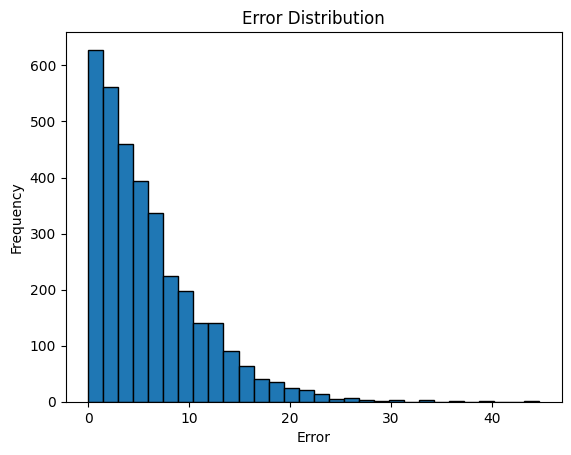

In [21]:
import matplotlib.pyplot as plt

plt.hist(df['ERROR'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

In [22]:
# Identfy unique list of cluster to loop over
dataset_clusters.head()

,PLAYER,CLUSTER
0,nicolas batum,0
1,deni avdija,12
2,alperen sengun,3
3,amir coffey,4
4,jaden mcdaniels,4


In [23]:
clusterList = dataset_clusters['CLUSTER'].tolist()

In [24]:
uniqueClusterList = list(set(clusterList))
uniqueClusterList

['8',
 '3',
 '14',
 '5',
 '0',
 '10',
 '11',
 nan,
 '9',
 '13',
 '6',
 '1',
 '2',
 '4',
 '7',
 '12']

In [25]:
# ClusterError = 0
# for cluster in uniqueClusterList:
#     clusterdf = dataset[dataset['CLUSTER'] == cluster]
#     dfFeatures = clusterdf[['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg']]
#     dfLabels = clusterdf[['FP']]

#     labels = np.array(dfLabels).ravel()
#     features = np.array(dfFeatures)

#     train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=4)

#     reg = RandomForestRegressor(random_state=4)
#     reg.fit(train, train_labels)

#     train_predictions = reg.predict(train)
#     predictions = reg.predict(test)

#     df0 = pd.DataFrame(test, columns = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg'])
#     df0['Actual'] = test_labels
#     df0['Predicted'] = predictions
#     df0['Error'] = abs(df0['Actual'] - df0['Predicted'])
#     ClusterError += df0['Error'].mean()

#     print(f"Cluster {cluster} average error is roughly {df0['Error'].mean()}")
# avgClusterError = ClusterError/len(uniqueClusterList)
# print(f"Average error across clusters is: {avgClusterError}")